In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from tqdm.auto import tqdm
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_images_path = "/content/drive/MyDrive/project/x-rays-pneumonia/train_images/train_images"
test_images_path = "/content/drive/MyDrive/project/x-rays-pneumonia/test_images/test_images"

In [4]:
data_path = "/content/drive/MyDrive/project/x-rays-pneumonia/labels_train.csv"

In [5]:
train = pd.read_csv(data_path)

In [6]:
train.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


- Class 0: no disease

- Class 1: bacterial pneumonia

- Class 2: viral pneumonia

In [7]:
batch_size = 32
img_size = 256
epochs = 10
lr = 0.0001

In [8]:
class PneumoniaDataset:
    def __init__(self, df, transform):
        self.df = df
        self.file_names = df['file_name'].values
        self.targets = df['class_id'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = Image.open(os.path.join(train_images_path, file_path))
        target = self.targets[idx]

        if self.transform is not None:
            image = self.transform(image).float()

        image = image
        target = torch.tensor(target, dtype=torch.long)

        return {
            "image": image,
            "target": target
        }

In [9]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

In [10]:
dataset = PneumoniaDataset(train, transform=transform)
print(dataset[1])

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'target': tensor(2)}


In [11]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3270, 1402)

In [12]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers = os.cpu_count())
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size*2,shuffle=False, num_workers = os.cpu_count())

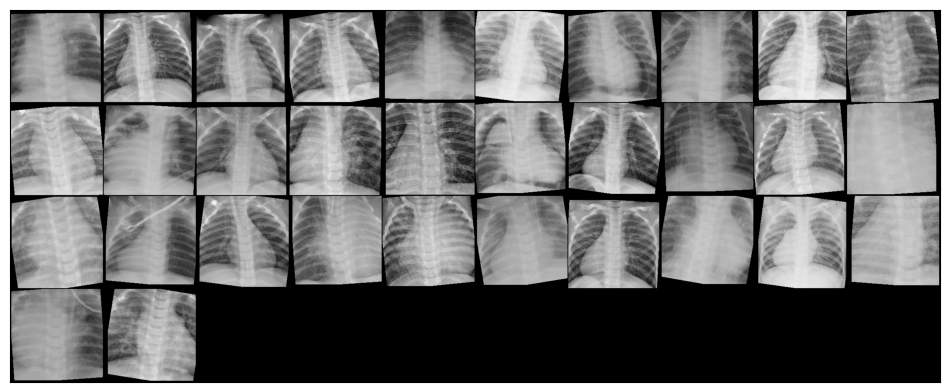

In [13]:
def show_batch(dl):
    for data in dl:
        images = data['image']
        targets = data['target']
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images[:60], nrow=10).permute(1,2,0))
        break

show_batch(train_loader)

In [14]:
class PneumoniaModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision.models.resnet50(pretrained=True)
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        for param in self.network.fc.parameters(): # freezing layers
            param.require_grad = False

        num_features = self.network.fc.in_features  # get number of features of last layer
        self.network.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.network(x)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [16]:
model = PneumoniaModel()
output = model(train_ds[0]['image'].unsqueeze(0))
print(output)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


tensor([[-0.0581,  0.0404, -0.0949]], grad_fn=<AddmmBackward0>)


In [21]:
!pip install torchviz --quiet
import torch
from torch import nn
import torchvision
from torchviz import make_dot
from google.colab import drive


# Generate a visualization of the model graph
x = torch.randn(1, 1, 224, 224).to(device)  # Sample input shape
y = model(x)

# Plot the graph
make_dot(y, params=dict(model.named_parameters())).render("/content/drive/My Drive/project/models/pneumonia_model_graph", format="png")

  Preparing metadata (setup.py) ... done


'/content/drive/My Drive/project/models/pneumonia_model_graph.png'

In [27]:
from PIL import Image
from IPython.display import display

# Path to the image
image_path = "/content/drive/My Drive/project/models/pneumonia_model_graph.png"

# Open and display the image
image = Image.open(image_path)
display(image)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [24]:
def calculate_accuracy(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    accuracy = torch.tensor(torch.sum(preds == targets).item() / len(preds))
    accuracy = accuracy.detach().numpy()
    return accuracy

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_avg_auc(targets, outputs):
    softmax = nn.Softmax(dim=1)
    outputs_prob = softmax(outputs)

    targets = targets.detach().cpu().numpy()
    targets = label_binarize(targets, classes=[0, 1, 2])
    outputs = outputs_prob.detach().cpu().numpy()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(targets[:, i], outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])



    fpr["micro"], tpr["micro"], _ = roc_curve(targets.ravel(), outputs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr["micro"], tpr["micro"], roc_auc

In [25]:
def train_fn(train_loader, optimizer, criterion, epoch):


    model.train()


    tk0 = tqdm(train_loader, total=len(train_loader))


    losses = AverageMeter()
    accuracies = AverageMeter()
    aucs = AverageMeter()
    tprs = AverageMeter()
    fprs = AverageMeter()


    for batch_idx, data in enumerate(tk0):
        tk0.set_description(f"Epoch: {epoch + 1} [train]")
        images = data['image']
        targets = data['target']
        images = images.to(device)   # images to GPU
        targets = targets.to(device) # targets to GPU

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)
        accuracy = calculate_accuracy(outputs, targets)
        loss.backward()
        optimizer.step()

        fpr, tpr, auc = calculate_avg_auc(targets, outputs)

        losses.update(loss.item(), batch_size)
        accuracies.update(accuracy.item(), batch_size)
        aucs.update(auc['micro'].item(), batch_size)
        tprs.update(tpr.mean(), batch_size)
        fprs.update(fpr.mean(), batch_size)


        tk0.set_postfix({
            "loss": losses.avg,
            "accuracy": accuracies.avg,
            "auc": aucs.avg,
            "fpr": fprs.avg,
            "tpr": tprs.avg
        })

    return losses.avg, aucs.avg

def eval_fn(valid_loader, epoch):


    model.eval()

    tk0 = tqdm(valid_loader, total=len(valid_loader))


    losses = AverageMeter()
    accuracies = AverageMeter()
    aucs = AverageMeter()
    tprs = AverageMeter()
    fprs = AverageMeter()

    for batch_idx, data in enumerate(tk0):
        tk0.set_description(f"Epoch: {epoch + 1} [eval]")
        images = data['image']
        targets = data['target']
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)
        accuracy = calculate_accuracy(outputs, targets)

        fpr, tpr, auc = calculate_avg_auc(targets, outputs)

        losses.update(loss.item(), batch_size)
        accuracies.update(accuracy.item(), batch_size)
        aucs.update(auc['micro'].item(), batch_size)
        tprs.update(tpr.mean(), batch_size)
        fprs.update(fpr.mean(), batch_size)

        tk0.set_postfix({
            "loss": losses.avg,
            "accuracy": accuracies.avg,
            "auc": aucs.avg,
            "fpr": fprs.avg,
            "tpr": tprs.avg
        })

    return losses.avg, aucs.avg

In [28]:
best_auc = 0

for epoch in range(epochs):
    train_loss, train_auc = train_fn(train_loader, optimizer, criterion, epoch)
    val_loss, val_auc = eval_fn(valid_loader, epoch)


    if val_auc > best_auc:
        tqdm.write(f"ROC-AUC increased from {best_auc:.4f} -> {val_auc:.4f}, saving model")
        best_auc = val_auc
        torch.save(model.state_dict(), "resnet50_model.pth")

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.0000 -> 0.9069, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9069 -> 0.9195, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9195 -> 0.9300, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9300 -> 0.9312, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9312 -> 0.9369, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9369 -> 0.9413, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

ROC-AUC increased from 0.9413 -> 0.9461, saving model


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [29]:
def predict(index):

    model.load_state_dict(torch.load("./resnet50_model.pth"))
    model.eval()
    output = model(val_ds[index]['image'].unsqueeze(0).to(device))
    expected = val_ds[index]['target']
    fin_output = torch.argmax(output)
    print(f"Model output: {fin_output}")
    print(f"Expected :    {expected}")

In [30]:
for i in range(50):
    predict(i)
    print("-"*20)

Model output: 1
Expected :    1
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 1
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 1
Expected :    1
--------------------
Model output: 2
Expected :    2
--------------------
Model output: 0
Expected :    0
--------------

In [31]:
import torchvision.models as models

# Load a transfered ResNet model
model = PneumoniaModel()

# Print the names and modules of the layers
for name, module in model.named_children():
    print(name, module)

network ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str